In [163]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl

In [164]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel("/kaggle/input/eth-data/processed_data.xlsx")

# Gán index với cột 'Close'
df1 = df.reset_index()['Close']

In [165]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [166]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [167]:
test_size,train_size

(192, 1727)

In [168]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1 + 1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [169]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)

combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, ytest = create_dataset(combined_data, time_step)

In [170]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
ytest = ytest.reshape(-1, 1)

In [171]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", ytest.shape)

x_train shape: (1627, 100, 1)
y_train shape: (1627,)
x_test shape: (192, 100, 1)
y_test shape: (192, 1)


In [172]:
ftrl_optimizer = Ftrl(learning_rate = 0.001, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [173]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100, return_sequences=True))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))  # Output layer
model.compile(optimizer = ftrl_optimizer, loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_27 (GRU)                    │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 100, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [174]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1422 - val_loss: 0.3535
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1498 - val_loss: 0.3489
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1362 - val_loss: 0.3452
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1494 - val_loss: 0.3422
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1356 - val_loss: 0.3396
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1327 - val_loss: 0.3372
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1404 - val_loss: 0.3350
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1383 - val_loss: 0.3330
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1352 - val_loss: 0.3311
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1340 - val_loss: 0.3293
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1323 - val_loss: 0.3276
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [175]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [176]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest)

In [177]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 2342.135716470405
Testing MAE: 2269.789311091105
Testing MAPE: 77.7470897801694%


<h2> Predict 30, 60, 90 days

In [178]:
def predict_days(model, start_input, n_steps, predict_days):
    temp_input = list(start_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    i = 0
    while i < predict_days:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[-n_steps:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return lst_output

In [179]:
n_steps = 100

# Get the last 100 data points from the test data
x_input = test_data[-100:].reshape(1, -1)

# Predict 30, 60, and 90 days ahead
output_30_days = predict_days(model, x_input, n_steps, 30)
output_60_days = predict_days(model, x_input, n_steps, 60)
output_90_days = predict_days(model, x_input, n_steps, 90)

output_30_days = np.array(output_30_days).reshape(-1, 1)
output_60_days = np.array(output_60_days).reshape(-1, 1)
output_90_days = np.array(output_90_days).reshape(-1, 1)

output_30_days = scaler.inverse_transform(output_30_days)
output_60_days = scaler.inverse_transform(output_60_days)
output_90_days = scaler.inverse_transform(output_90_days)

<h3> Visualize

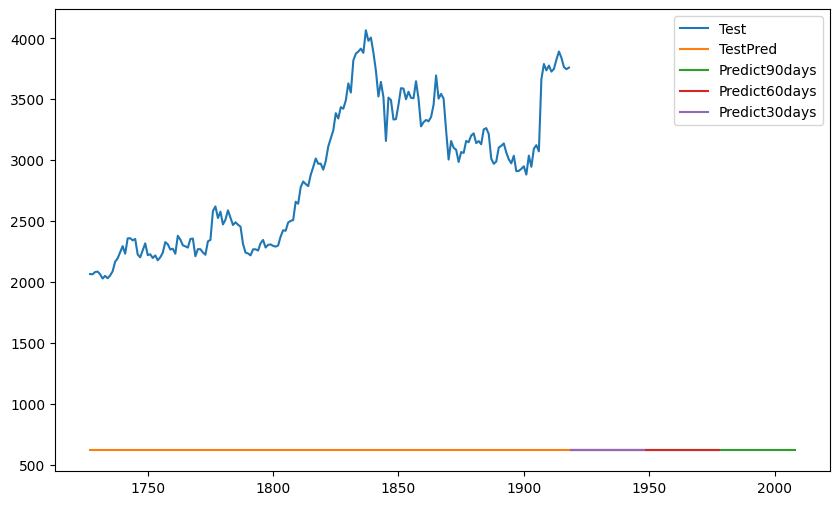

In [180]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
predict_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
predict_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
predict_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)

plt.figure(figsize=(10, 6))

plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='TestPred')
plt.plot(predict_90_days_index, output_90_days, label='Predict90days')
plt.plot(predict_60_days_index, output_60_days, label='Predict60days')
plt.plot(predict_30_days_index, output_30_days, label='Predict30days')

plt.legend()
plt.show()